# Lets Create Some Random Graphs

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random

In [2]:
'''
Idea: generar un grafo completo. Recorrerlo usando DFS desde un nodo elegido al azar.
Para cada arista que no sea puente, tomar una muestra de una variable aleatoria y eliminar
la arista si la variable supera cierto umbral. A grandes rasgos, el procedimiento consiste
en eliminar cierto porcentaje esperado de backedges.
'''

def sacarBackedges(n, grafo, p_backedge=0.5):
    # Elimina cada backedge de un grafo con una probabilidad 1.0 - p_backedge.
    vecinosYPesos = [ [] for i in range(n) ]

    for e in grafo:
        vecinosYPesos[e[0] - 1].append([ e[1], e[2] ])
        vecinosYPesos[e[1] - 1].append([ e[0], e[2] ])

    color = dict([ (i+1, "blanco") for i in range(n) ])
    backedges = backedgesDFS(vecinosYPesos, color, 1, -1, [])

    for b in backedges:
        p = np.random.uniform()
        if p >= p_backedge:
            grafo.remove(b)
    

def backedgesDFS(vecinosYPesos, color, v, padre, res):
    color[v] = "gris"

    for t in vecinosYPesos[v-1]:
        w = t[0]
        if color[w] == "blanco":
            backedgesDFS(vecinosYPesos, color, w, v, res)
        if color[w] == "gris" and w != v and w != padre:
            l, r = min(v,w), max(v,w)
            res.append([l, r, t[1]])

    color[v] = "negro"

    return res

def generarGrafoAleatorioPesosNormales(n, mu=5, sigma=1, p_backedge=0.5):
    # Genera un grafo completo representado por una lista de aristas.
    # El nodo de menor índice aparece antes, pero los pares no son ordenados
    # (es decir, el grafo no es dirigido).
    grafo = []
    pesoActual = 0
    for i in range(1, n):
        for j in range(i+1, n+1):
            grafo.append( [i, j, int(max(np.random.normal(mu, sigma), 0))] )
            pesoActual += 1

    sacarBackedges(n, grafo, p_backedge)

    grafoStr = [ " ".join( str(k) for k in e ) for e in grafo ]

    return grafoStr

def generarArbol(n, h):
    assert(n>=h)
    # Genera un árbol de n vértices con ramas de altura h.
    r = (n-1) // h # Cantidad de ramas de altura exactamente h
    s = r if (n-1)%h == 0 else r+1
    arbol = [ [ 1, 2 + h*i, 1 ] for i in range(s) ]
    
    # Agrega las ramas de altura h
    for i in range(r):
        for j in range(2, h+1):
            arbol.append([ j + i*h, j + i*h + 1, 1 ])
            
    for i in range((n-1) % h - 1):
        arbol.append([ i + 2 + h*r, i + 3 + h*r, 1 ])
        
    arbolStr = [ " ".join( str(k) for k in e ) for e in arbol ]
    
    return arbolStr

def generarEntradaPesosNormales(n, mu=5, sigma=1, p_backedge=0.5, archivo="output"):
    # Genera un caso de test con 50 grafos de 5 a n nodos. Los pesos están distribuidos
    # uniformemente según los parámetros especificados.
    with open(archivo, 'w') as entrada:
        for k in range(5,n+1):
            for i in range(50):
                grafo = generarGrafoAleatorioPesosNormales(k, mu, sigma, p_backedge)
                entrada.write(str(k) + " " + str(len(grafo)) + '\n')
                for j in grafo:
                    entrada.write(j + '\n')
        entrada.write("0 0\n")
        
def generarEntradaArboles(n, h, archivo="output"):
    # Genera un caso de test con 50 árboles de altura 1 a h.
    with open(archivo, 'w') as entrada:
        for k in range(1,h+1):
            for i in range(50):
                grafo = generarArbol(n, k)
                entrada.write(str(n) + " " + str(len(grafo)) + '\n')
                for j in grafo:
                    entrada.write(j + '\n')
        entrada.write("0 0\n")

In [49]:
maxNumberOfNodes = 40

for p_backedges in np.arange(0,1.01,0.25):
    generarEntradaPesosNormales(maxNumberOfNodes,5,1,p_backedges,"./tests/normales_p_{0}.test-in".format(p_backedges))

# Corremos el experimento

In [11]:
! make expe

In [12]:
results ={}

for p_backedges in np.arange(0,1.01,0.25):
    results["dfNormal_{0}".format(p_backedges)] = pd.read_csv("./experimentacion/normales_p_{0}.stderr".format(p_backedges), delimiter=";")



In [13]:
results["dfNormal_1.0"].head()

,Cantidad de Nodos,Cantidad de Ejes,Tiempo generando Mst,Tiempo calculando raiz,Altura del arbol
0,5,10,0.000009,0.000008,4
1,5,10,0.000006,0.000007,5
2,5,10,0.000006,0.000006,5
3,5,10,0.000005,0.000006,4
4,5,10,0.000005,0.000006,4


In [14]:
for key, value in results.items():
    results[key] = value.groupby("Cantidad de Nodos").mean()
# dfNormal = dfNormal.groupby("Cantidad de Nodos").mean()
results["dfNormal_1.0"]

,Cantidad de Ejes,Tiempo generando Mst,Tiempo calculando raiz,Altura del arbol
Cantidad de Nodos,,,,
5,10.0,0.000005,0.000006,4.36
6,15.0,0.000007,0.000006,5.00
7,21.0,0.000009,0.000007,5.60
8,28.0,0.000011,0.000007,6.22
9,36.0,0.000013,0.000007,6.30
10,45.0,0.000016,0.000008,6.58
11,55.0,0.000020,0.000009,7.36
12,66.0,0.000022,0.000008,7.16
13,78.0,0.000025,0.000009,8.02


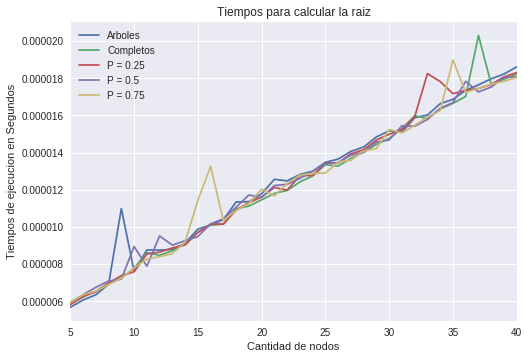

In [18]:
df = pd.DataFrame({'Arboles': results["dfNormal_0.0"]['Tiempo calculando raiz'],
                  'P = 0.25': results["dfNormal_0.25"]['Tiempo calculando raiz'],
                  'P = 0.5': results["dfNormal_0.5"]['Tiempo calculando raiz'],
                  'P = 0.75': results["dfNormal_0.75"]['Tiempo calculando raiz'],
                  'Completos': results["dfNormal_1.0"]['Tiempo calculando raiz']})

ax = df.plot(logy=False)
ax.set_ylabel("Tiempos de ejecucion en Segundos")
ax.set_xlabel("Cantidad de nodos")

plt.title("Tiempos para calcular la raiz")
plt.show()

In [25]:
dfComp = pd.DataFrame()
dfComp['Cantidad de Nodos'] = results["dfNormal_1.0"].index.values
dfComp['Complejidad n**2'] = [n**2 for n in results["dfNormal_0.0"].index.values]
dfComp['Complejidad n'] = [n for n in results["dfNormal_0.0"].index.values]

dfComp['Tiempo de calculo de raiz'] =  results["dfNormal_1.0"]['Tiempo calculando raiz']
dfComp['Tiempo en segundos de arboles'] =  results["dfNormal_0.0"]['Tiempo calculando raiz']
plt.clf()
correlation = dfComp.corr()
correlation

,Cantidad de Nodos,Complejidad n**2,Complejidad n,Tiempo de calculo de raiz,Tiempo en segundos de arboles
Cantidad de Nodos,1.000000,0.979388,1.000000,0.998506,0.978667
Complejidad n**2,0.979388,1.000000,0.979388,0.983704,0.961251
Complejidad n,1.000000,0.979388,1.000000,0.998506,0.978667
Tiempo de calculo de raiz,0.998506,0.983704,0.998506,1.000000,0.978155
Tiempo en segundos de arboles,0.978667,0.961251,0.978667,0.978155,1.000000


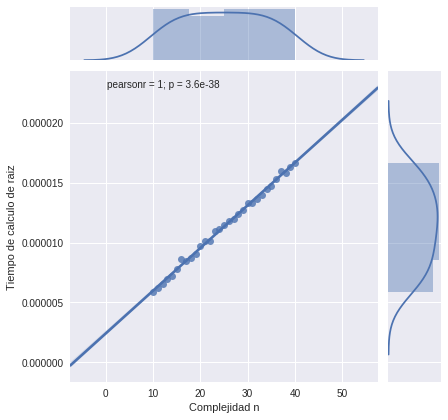

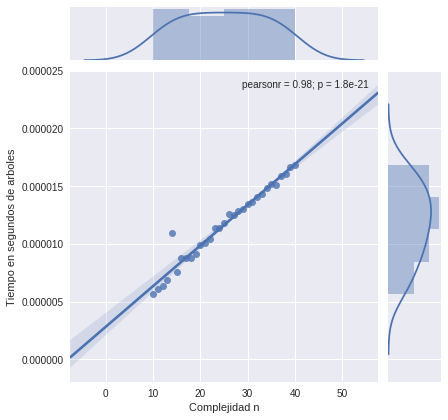

In [26]:
sns.jointplot(dfComp['Complejidad n'], dfComp['Tiempo de calculo de raiz'], kind="reg")
sns.jointplot(dfComp['Complejidad n'], dfComp['Tiempo en segundos de arboles'], kind="reg")


plt.show()

In [26]:
dfRoot = pd.DataFrame({'Arboles': results["dfNormal_0.0"]['Tiempo calculando raiz'],
                  'P = 0.25': results["dfNormal_0.25"]['Tiempo calculando raiz'],
                  'P = 0.5': results["dfNormal_0.5"]['Tiempo calculando raiz'],
                  'P = 0.75': results["dfNormal_0.75"]['Tiempo calculando raiz'],
                  'Completos': results["dfNormal_1.0"]['Tiempo calculando raiz']})

ax = dfRoot.plot(logy=False)
ax.set_ylabel("Tiempos de ejecución en Segundos")
ax.set_xlabel("Cantidad de nodos")

plt.title("Tiempos para encontrar el MST")
plt.show()

In [22]:
dfComp = pd.DataFrame()
dfComp['Cantidad de Nodos'] = results["dfNormal_1.0"].index.values
dfComp['Complejidad n**2'] = [100 + random.normalvariate(n**2,2) for n in results["dfNormal_0.0"].index.values]
dfComp['Complejidad n'] = [100 + random.normalvariate(n,0.3) for n in results["dfNormal_0.0"].index.values]

dfComp['Tiempo de encontrar raiz en segundos de ex-completos'] =  results["dfNormal_1.0"]['Tiempo calculando raiz']
dfComp['Tiempo de encontrar raiz en segundos de arboles'] =  results["dfNormal_0.0"]['Tiempo calculando raiz']
plt.clf()
correlation = dfComp.corr()
correlation

,Cantidad de Nodos,Complejidad n**2,Complejidad n,Tiempo de encontrar raiz en segundos de ex-completos,Tiempo de encontrar raiz en segundos de arboles
Cantidad de Nodos,1.000000,0.979354,0.999647,0.998468,0.992528
Complejidad n**2,0.979354,1.000000,0.977952,0.982568,0.971845
Complejidad n,0.999647,0.977952,1.000000,0.997868,0.992121
Tiempo de encontrar raiz en segundos de ex-completos,0.998468,0.982568,0.997868,1.000000,0.992570
Tiempo de encontrar raiz en segundos de arboles,0.992528,0.971845,0.992121,0.992570,1.000000


In [24]:
sns.jointplot(dfComp['Complejidad n'], dfComp['Tiempo de encontrar raiz en segundos de ex-completos'], kind="reg")
sns.jointplot(dfComp['Complejidad n'], dfComp['Tiempo de encontrar raiz en segundos de arboles'], kind="reg")

plt.show()

# Experimento para altura del arbol 

In [16]:
for n in np.arange(20,101,20):
    generarEntradaArboles(n,n,"./tests/arboles_de_{0}_nodos.test-in".format(n))

In [17]:
!make expe

In [21]:
results ={}

for n in np.arange(20,101,20):
    results["dfArboles_{0}".format(n)] = pd.read_csv("./experimentacion/arboles_de_{0}_nodos.stderr".format(n), delimiter=";")



In [23]:
for key, value in results.items():
    results[key] = value.groupby("Altura del arbol").mean()
# dfNormal = dfNormal.groupby("Cantidad de Nodos").mean()
results["dfArboles_80"]

,Cantidad de Nodos,Cantidad de Ejes,Tiempo generando Mst,Tiempo calculando raiz
Altura del arbol,,,,
3,80,79,0.000045,0.000026
5,80,79,0.000051,0.000026
7,80,79,0.000053,0.000027
9,80,79,0.000054,0.000027
11,80,79,0.000054,0.000027
13,80,79,0.000055,0.000027
15,80,79,0.000055,0.000027
17,80,79,0.000055,0.000027
19,80,79,0.000058,0.000031


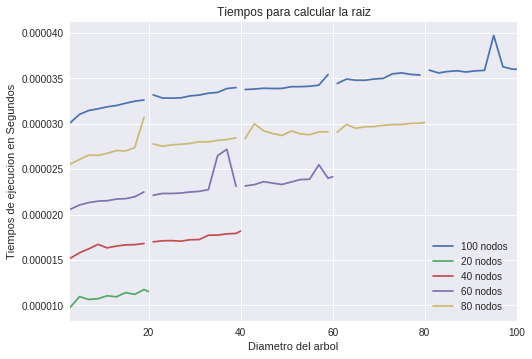

In [26]:
df = pd.DataFrame({'20 nodos': results["dfArboles_20"]['Tiempo calculando raiz'],
                  '40 nodos': results["dfArboles_40"]['Tiempo calculando raiz'],
                  '60 nodos': results["dfArboles_60"]['Tiempo calculando raiz'],
                  '80 nodos': results["dfArboles_80"]['Tiempo calculando raiz'],
                  '100 nodos': results["dfArboles_100"]['Tiempo calculando raiz']})

ax = df.plot(logy=False)
ax.set_ylabel("Tiempos de ejecucion en Segundos")
ax.set_xlabel("Diametro del arbol")

plt.title("Tiempos para calcular la raiz")
plt.show()